# Introduction to Cross-Validation - Lab

## Introduction

In this lab, you'll be able to practice your cross-validation skills!


## Objectives

You will be able to:

- Perform cross validation on a model to determine optimal model performance
- Compare training and testing errors to determine if model is over or underfitting

## Let's get started

We included the code to pre-process below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

ames = pd.read_csv('ames.csv')

continuous = ['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
categoricals = ['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']

ames_cont = ames[continuous]

# log features
log_names = [f'{column}_log' for column in ames_cont.columns]

ames_log = np.log(ames_cont)
ames_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

ames_log_norm = ames_log.apply(normalize)

# one hot encode categoricals
ames_ohe = pd.get_dummies(ames[categoricals], prefix=categoricals, drop_first=True)

preprocessed = pd.concat([ames_log_norm, ames_ohe], axis=1)

X = preprocessed.drop('SalePrice_log', axis=1)
y = preprocessed['SalePrice_log']

### Train-test split

Perform a train-test split with a test set of 20%.

In [2]:
# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

In [3]:
# Split the data into training and test sets (assign 20% to test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [4]:
# A brief preview of train-test split
print(len(X_train), len(X_test), len(y_train), len(y_test))


1168 292 1168 292


### Fit the model

Fit a linear regression model and apply the model to make predictions on test set

In [5]:
# Your code here
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

### Residuals and MSE

Calculate the residuals and the mean squared error on the test set

In [6]:
# Your code here
from sklearn.metrics import mean_squared_error
test_res = y_hat_test - y_test

test_mse = mean_squared_error(y_test, y_hat_test)
print(f'Test MSE: {test_mse}')

Test MSE: 0.17364565386906397


## Cross-Validation: let's build it from scratch!

### Create a cross-validation function

Write a function `kfolds()` that splits a dataset into k evenly sized pieces. If the full dataset is not divisible by k, make the first few folds one larger then later ones.

We want the folds to be a list of subsets of data!

In [7]:
def kfolds(data, k):
    # Force data as pandas DataFrame
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1, k+1):
        if fold_n <= leftovers:
            fold = data.iloc[start_obs : start_obs+fold_size+1]
            folds.append(fold)
            start_obs += fold_size + 1
        else:
            fold = data.iloc[start_obs : start_obs+fold_size]
            folds.append(fold)
            start_obs += fold_size
            
    return folds

### Apply it to the Ames Housing data

In [8]:
# Make sure to concatenate the data again
ames_data = pd.concat([X.reset_index(drop=True), y], axis=1)

In [9]:
# Apply kfolds() to ames_data with 5 folds
ames_folds = kfolds(ames_data, 5)

### Perform a linear regression for each fold and calculate the training and test error

Perform linear regression on each and calculate the training and test error: 

In [11]:
test_errs = []
train_errs = []
k=5

for n in range(k):
    # Split in train and test for the fold
    train = pd.concat([fold for i, fold in enumerate(ames_folds) if i!=n])
    test = ames_folds[n]
    # Fit a linear regression model
    X_train = train.drop('SalePrice_log', axis=1)
    y_train = train['SalePrice_log']
    X_test = test.drop('SalePrice_log', axis=1)
    y_test = test['SalePrice_log']
    linreg.fit(X_train, y_train)
    # Evaluate Train and Test errors
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_res = y_hat_train - y_train
    test_res = y_hat_test - y_test
    train_errs.append(np.mean(train_res)**2)
    test_errs.append(np.mean(test_res)**2)
print(train_errs)
print(test_errs)

[3.518065762927962e-33, 1.335986051720704e-32, 2.3129952418987255e-36, 1.945228998436828e-33, 1.7306408648696742e-32]
[0.0013822559412533682, 0.000302485642463891, 0.0007135418821295605, 0.0014885833272440944, 0.0016728114564401588]


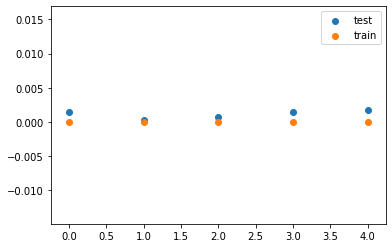

In [17]:
plt.scatter(range(k), test_errs, label='test')
plt.scatter(range(k), train_errs, label='train')
plt.legend()

## Cross-Validation using Scikit-Learn

This was a bit of work! Now, let's perform 5-fold cross-validation to get the mean squared error through scikit-learn. Let's have a look at the five individual MSEs and explain what's going on.

In [20]:
# Your code here
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error)

cv_5_result = cross_val_score(linreg, X, y, cv=5, scoring=mse)

Next, calculate the mean of the MSE over the 5 cross-validation and compare and contrast with the result from the train-test split case.

In [22]:
# Your code here
cv_5_result.mean()

0.1770283421000112

##  Summary 

Congratulations! You are now familiar with cross-validation and know how to use `cross_val_score()`. Remember that the results obtained from cross-validation are robust and always use it whenever possible! 